In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import pandas as pd
import elmo_dataset as ds
import nltk
import unicodedata
import re

In [3]:
def preprocess(csv):
    df = pd.read_csv(csv)

    df = df.dropna()
    df = df.reset_index(drop=True)

    def normalize_unicode(s):
        return unicodedata.normalize('NFD', s)

    def preprocess_text(text):
        text = normalize_unicode(text)
        text = re.sub(r"(.)(\1{2,})", r"\1", text)
        text = re.sub(r"[^a-zA-Z.,!?]+", " ", text)
        text = text.strip().lower()
        return text

    nltk.download('punkt')

    df['Description'] = df['Description'].apply(preprocess_text)
    df['Description'] = df['Description'].apply(nltk.word_tokenize)

    return df

train_df = preprocess('/content/drive/MyDrive/train.csv')
test_df = preprocess('/content/drive/MyDrive/test.csv')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
PRE_TRAIN_SET = 8000
PRE_VAL_SET = 2000
DOWNSTREAM_TRAIN_SET = 80000
DOWNSTREAM_VAL_SET = 20000

In [5]:
train_set = list(train_df['Description'])
pre_train_set = train_set[:PRE_TRAIN_SET]
pre_val_set = train_set[PRE_TRAIN_SET:PRE_TRAIN_SET+PRE_VAL_SET]

In [6]:
vocab = ds.ELMO_Dataset.create_vocab(train_set)
word_to_ix = {word: idx for idx, word in enumerate(vocab)}
print(len(word_to_ix))

59352


In [7]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    padded_batch = pad_sequence(batch, batch_first=True, padding_value=word_to_ix['<pad>'])
    lengths = torch.LongTensor([len(x) for x in batch])

    input_tensor = torch.LongTensor(padded_batch[:, :-1])
    target_truth = torch.LongTensor(padded_batch[:, 1:])

    return input_tensor, target_truth, lengths - 1

In [8]:
from torch.utils.data import DataLoader

forward_pre_train_dataset = ds.ELMO_Dataset(pre_train_set, word_to_ix, 'Forward')
forward_pre_val_dataset = ds.ELMO_Dataset(pre_val_set, word_to_ix, 'Forward')

backward_pre_train_dataset = ds.ELMO_Dataset(pre_train_set, word_to_ix, 'Backward')
backward_pre_val_dataset = ds.ELMO_Dataset(pre_val_set, word_to_ix, 'Backward')

batch_size = 32

forward_pre_train_loader = DataLoader(forward_pre_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=2)
forward_pre_val_loader = DataLoader(forward_pre_val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=2)

backward_pre_train_loader = DataLoader(backward_pre_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=2)
backward_pre_val_loader = DataLoader(backward_pre_val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=2)

In [9]:
import gensim
import gensim.downloader

glove_vectors = gensim.downloader.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [10]:
import numpy as np

def embedding_matrix(word_to_ix, glove_vectors):
    embedding_dim = glove_vectors.vector_size
    embedding_matrix = np.zeros((len(word_to_ix), embedding_dim))

    average_vector = np.mean(glove_vectors.vectors, axis=0)

    special_token_embeddings = {
        '<pad>': np.zeros(embedding_dim),
        '<unk>': average_vector,
        '<sos>': np.random.randn(embedding_dim),
        '<eos>': np.random.randn(embedding_dim)
    }

    for word, i in word_to_ix.items():
        if word in glove_vectors:
            embedding_vector = glove_vectors[word]
        else:
            embedding_vector = special_token_embeddings.get(word, average_vector)

        embedding_matrix[i] = embedding_vector

    print(embedding_matrix.shape)

    return torch.FloatTensor(embedding_matrix)

In [11]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class ELMO(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_layers, dropout, filename=None):
        super(ELMO, self).__init__()

        self.embedding_matrix = embedding_matrix
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.forward_lstm = nn.LSTM(embedding_matrix.shape[1], hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.backward_lstm = nn.LSTM(embedding_matrix.shape[1], hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.forward_linear = nn.Linear(hidden_dim, embedding_matrix.shape[0])
        self.backward_linear = nn.Linear(hidden_dim, embedding_matrix.shape[0])

        if filename:
            self.load_state_dict(torch.load(filename), strict=False)

    def forward(self, input_tensor, lengths, forward):
        embedded = self.embedding(input_tensor)
        output = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        if forward:
            output, (h_n, c_n) = self.forward_lstm(output, None)
            output, _ = pad_packed_sequence(output, batch_first=True)
            output = self.forward_linear(output)
        else:
            output, (h_n, c_n) = self.backward_lstm(output, None)
            output, _ = pad_packed_sequence(output, batch_first=True)
            output = self.backward_linear(output)

        return output, h_n, c_n, embedded

In [12]:
from tqdm import tqdm

def run_epoch(model, data_loader, loss_fn, epoch, forward, optimizer=None):
    if optimizer:
        model.train()
    else:
        model.eval()

    total_loss = 0
    p_bar = tqdm(data_loader)

    for (input_tensor, target_truth, lengths) in p_bar:

        input_tensor = input_tensor.cuda()
        target_truth = target_truth.cuda()

        output, _, _, _= model(input_tensor, lengths, forward)
        output = output.reshape(-1, output.shape[2])

        target_truth = target_truth.reshape(-1)
        loss = loss_fn(output, target_truth)
        total_loss += loss.item()

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        mean_loss = total_loss / len(data_loader)

        p_bar.set_description(f'{"T" if optimizer else "V"} Loss: {mean_loss:.4f}, count: {epoch}')

    return mean_loss

In [13]:
import torch.nn as nn


def train(optimizer, embedding_dimension, hidden_dimension, dropout_rate, learning_rate):
    num_epochs = 50

    glove_vectors = gensim.downloader.load(f'glove-wiki-gigaword-{embedding_dimension}')
    loss_fn = nn.CrossEntropyLoss(ignore_index=word_to_ix['<pad>'])

    model = ELMO(embedding_matrix(word_to_ix, glove_vectors), hidden_dimension, 1, dropout_rate)

    optimizer = getattr(torch.optim, optimizer)(model.parameters(), lr=learning_rate)

    model.cuda()

    best_val_loss = float('inf')

    all_val_loss = []
    all_train_loss = []

    for epoch in range(num_epochs):

        forward_train_loss = run_epoch(model, forward_pre_train_loader, loss_fn, epoch+1, 1, optimizer)
        backward_train_loss = run_epoch(model, backward_pre_train_loader, loss_fn, epoch+1, 0, optimizer)

        with torch.no_grad():
            forward_val_loss = run_epoch(model, forward_pre_val_loader, loss_fn, epoch+1, 1)
            backward_val_loss = run_epoch(model, backward_pre_val_loader, loss_fn, epoch+1, 0)

        print('Epoch: {}, F Train Loss: {:.4f}, F Val Loss: {:.4f}'.format(epoch+1, forward_train_loss, forward_val_loss))
        print('Epoch: {}, B Train Loss: {:.4f}, B Val Loss: {:.4f}'.format(epoch+1, backward_train_loss, backward_val_loss))
        average_train_loss = (forward_train_loss + backward_train_loss) / 2
        average_val_loss = (forward_val_loss + backward_val_loss) / 2

        all_train_loss.append(average_train_loss)
        all_val_loss.append(average_val_loss)
        print('Average Train Loss: {:.4f}, Average Val Loss: {:.4f}'.format(average_train_loss, average_val_loss))
        print('-------------------------------------------------------')

        if average_val_loss < best_val_loss:
            counter = 0
            best_val_loss = average_val_loss
            torch.save(model.state_dict(), 'best_elmo_model.pth')
        else:
            counter += 1
            if counter == 3:
                break

    return all_train_loss, all_val_loss

In [14]:
all_emlo_train_loss, all_elmo_val_loss = train('Adam', 100, 100, 0.2, 0.001)

(59352, 100)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
V Loss: 7.1377, count: 1: 100%|██████████| 63/63 [00:01<00:00, 42.89it/s]


Epoch: 1, F Train Loss: 7.5269, F Val Loss: 7.1496
Epoch: 1, B Train Loss: 7.5311, B Val Loss: 7.1377
Average Train Loss: 7.5290, Average Val Loss: 7.1437
-------------------------------------------------------


V Loss: 6.9503, count: 2: 100%|██████████| 63/63 [00:01<00:00, 41.94it/s]


Epoch: 2, F Train Loss: 6.8465, F Val Loss: 6.9644
Epoch: 2, B Train Loss: 6.8316, B Val Loss: 6.9503
Average Train Loss: 6.8391, Average Val Loss: 6.9573
-------------------------------------------------------


V Loss: 6.7432, count: 3: 100%|██████████| 63/63 [00:01<00:00, 42.05it/s]


Epoch: 3, F Train Loss: 6.5904, F Val Loss: 6.7541
Epoch: 3, B Train Loss: 6.5717, B Val Loss: 6.7432
Average Train Loss: 6.5811, Average Val Loss: 6.7486
-------------------------------------------------------


V Loss: 6.5644, count: 4: 100%|██████████| 63/63 [00:01<00:00, 37.14it/s]


Epoch: 4, F Train Loss: 6.3392, F Val Loss: 6.5792
Epoch: 4, B Train Loss: 6.3183, B Val Loss: 6.5644
Average Train Loss: 6.3287, Average Val Loss: 6.5718
-------------------------------------------------------


V Loss: 6.4227, count: 5: 100%|██████████| 63/63 [00:01<00:00, 38.33it/s]


Epoch: 5, F Train Loss: 6.1190, F Val Loss: 6.4301
Epoch: 5, B Train Loss: 6.0983, B Val Loss: 6.4227
Average Train Loss: 6.1086, Average Val Loss: 6.4264
-------------------------------------------------------


V Loss: 6.3207, count: 6: 100%|██████████| 63/63 [00:01<00:00, 41.34it/s]


Epoch: 6, F Train Loss: 5.9288, F Val Loss: 6.3217
Epoch: 6, B Train Loss: 5.9173, B Val Loss: 6.3207
Average Train Loss: 5.9231, Average Val Loss: 6.3212
-------------------------------------------------------


V Loss: 6.2486, count: 7: 100%|██████████| 63/63 [00:01<00:00, 40.72it/s]


Epoch: 7, F Train Loss: 5.7666, F Val Loss: 6.2397
Epoch: 7, B Train Loss: 5.7662, B Val Loss: 6.2486
Average Train Loss: 5.7664, Average Val Loss: 6.2441
-------------------------------------------------------


V Loss: 6.1856, count: 8: 100%|██████████| 63/63 [00:01<00:00, 42.09it/s]


Epoch: 8, F Train Loss: 5.6239, F Val Loss: 6.1710
Epoch: 8, B Train Loss: 5.6334, B Val Loss: 6.1856
Average Train Loss: 5.6286, Average Val Loss: 6.1783
-------------------------------------------------------


V Loss: 6.1346, count: 9: 100%|██████████| 63/63 [00:01<00:00, 36.93it/s]


Epoch: 9, F Train Loss: 5.4959, F Val Loss: 6.1151
Epoch: 9, B Train Loss: 5.5118, B Val Loss: 6.1346
Average Train Loss: 5.5038, Average Val Loss: 6.1249
-------------------------------------------------------


V Loss: 6.0841, count: 10: 100%|██████████| 63/63 [00:01<00:00, 35.17it/s]


Epoch: 10, F Train Loss: 5.3809, F Val Loss: 6.0670
Epoch: 10, B Train Loss: 5.4033, B Val Loss: 6.0841
Average Train Loss: 5.3921, Average Val Loss: 6.0756
-------------------------------------------------------


V Loss: 6.0480, count: 11: 100%|██████████| 63/63 [00:01<00:00, 40.94it/s]


Epoch: 11, F Train Loss: 5.2751, F Val Loss: 6.0305
Epoch: 11, B Train Loss: 5.3014, B Val Loss: 6.0480
Average Train Loss: 5.2882, Average Val Loss: 6.0392
-------------------------------------------------------


V Loss: 6.0176, count: 12: 100%|██████████| 63/63 [00:01<00:00, 40.72it/s]


Epoch: 12, F Train Loss: 5.1802, F Val Loss: 5.9975
Epoch: 12, B Train Loss: 5.2054, B Val Loss: 6.0176
Average Train Loss: 5.1928, Average Val Loss: 6.0076
-------------------------------------------------------


V Loss: 5.9924, count: 13: 100%|██████████| 63/63 [00:01<00:00, 41.74it/s]


Epoch: 13, F Train Loss: 5.0891, F Val Loss: 5.9707
Epoch: 13, B Train Loss: 5.1174, B Val Loss: 5.9924
Average Train Loss: 5.1033, Average Val Loss: 5.9816
-------------------------------------------------------


V Loss: 5.9743, count: 14: 100%|██████████| 63/63 [00:01<00:00, 40.52it/s]


Epoch: 14, F Train Loss: 5.0062, F Val Loss: 5.9544
Epoch: 14, B Train Loss: 5.0340, B Val Loss: 5.9743
Average Train Loss: 5.0201, Average Val Loss: 5.9643
-------------------------------------------------------


V Loss: 5.9563, count: 15: 100%|██████████| 63/63 [00:01<00:00, 36.99it/s]


Epoch: 15, F Train Loss: 4.9259, F Val Loss: 5.9378
Epoch: 15, B Train Loss: 4.9548, B Val Loss: 5.9563
Average Train Loss: 4.9403, Average Val Loss: 5.9470
-------------------------------------------------------


V Loss: 5.9492, count: 16: 100%|██████████| 63/63 [00:01<00:00, 41.32it/s]


Epoch: 16, F Train Loss: 4.8535, F Val Loss: 5.9222
Epoch: 16, B Train Loss: 4.8813, B Val Loss: 5.9492
Average Train Loss: 4.8674, Average Val Loss: 5.9357
-------------------------------------------------------


V Loss: 5.9308, count: 17: 100%|██████████| 63/63 [00:01<00:00, 41.79it/s]


Epoch: 17, F Train Loss: 4.7865, F Val Loss: 5.9159
Epoch: 17, B Train Loss: 4.8132, B Val Loss: 5.9308
Average Train Loss: 4.7999, Average Val Loss: 5.9234
-------------------------------------------------------


V Loss: 5.9306, count: 18: 100%|██████████| 63/63 [00:01<00:00, 41.60it/s]


Epoch: 18, F Train Loss: 4.7198, F Val Loss: 5.9106
Epoch: 18, B Train Loss: 4.7479, B Val Loss: 5.9306
Average Train Loss: 4.7339, Average Val Loss: 5.9206
-------------------------------------------------------


V Loss: 5.9284, count: 19: 100%|██████████| 63/63 [00:01<00:00, 41.27it/s]


Epoch: 19, F Train Loss: 4.6569, F Val Loss: 5.9082
Epoch: 19, B Train Loss: 4.6849, B Val Loss: 5.9284
Average Train Loss: 4.6709, Average Val Loss: 5.9183
-------------------------------------------------------


V Loss: 5.9230, count: 20: 100%|██████████| 63/63 [00:01<00:00, 36.17it/s]


Epoch: 20, F Train Loss: 4.5999, F Val Loss: 5.9067
Epoch: 20, B Train Loss: 4.6280, B Val Loss: 5.9230
Average Train Loss: 4.6140, Average Val Loss: 5.9148
-------------------------------------------------------


V Loss: 5.9308, count: 21: 100%|██████████| 63/63 [00:01<00:00, 39.85it/s]


Epoch: 21, F Train Loss: 4.5435, F Val Loss: 5.9058
Epoch: 21, B Train Loss: 4.5716, B Val Loss: 5.9308
Average Train Loss: 4.5575, Average Val Loss: 5.9183
-------------------------------------------------------


V Loss: 5.9303, count: 22: 100%|██████████| 63/63 [00:01<00:00, 40.80it/s]


Epoch: 22, F Train Loss: 4.4915, F Val Loss: 5.9063
Epoch: 22, B Train Loss: 4.5194, B Val Loss: 5.9303
Average Train Loss: 4.5054, Average Val Loss: 5.9183
-------------------------------------------------------


V Loss: 5.9391, count: 23: 100%|██████████| 63/63 [00:01<00:00, 40.96it/s]


Epoch: 23, F Train Loss: 4.4412, F Val Loss: 5.9169
Epoch: 23, B Train Loss: 4.4688, B Val Loss: 5.9391
Average Train Loss: 4.4550, Average Val Loss: 5.9280
-------------------------------------------------------


In [15]:
from torch.utils.data import DataLoader, Dataset

class Downstream_Dataset(Dataset):
    def __init__(self, data_set, labels, word_to_ix):
        self.data_set = [['<sos>'] + x + ['<eos>'] for x in data_set]
        self.word_to_ix = word_to_ix
        self.indexed_data = [[word_to_ix.get(word, word_to_ix['<unk>']) for word in sentence] for sentence in self.data_set]
        self.labels = labels

    def __len__(self):
        return len(self.data_set)

    def __getitem__(self, idx):
        return torch.tensor(self.indexed_data[idx]), torch.tensor(self.indexed_data[idx][::-1]), torch.tensor(self.labels[idx])

In [16]:
from torch.nn.utils.rnn import pad_sequence

def downstream_collate_fn(batch):
    x_forward = pad_sequence([x[0] for x in batch], batch_first=True, padding_value=word_to_ix['<pad>'])
    x_backward = pad_sequence([x[1] for x in batch], batch_first=True, padding_value=word_to_ix['<pad>'])

    lengths = torch.LongTensor([len(x[0]) for x in batch])
    labels = torch.LongTensor([x[2] - 1 for x in batch])

    return x_forward, x_backward, lengths, labels

In [17]:
train_labels = list(train_df['Class Index'])

downstream_train_set = train_set[PRE_TRAIN_SET+PRE_VAL_SET:PRE_TRAIN_SET+PRE_VAL_SET+DOWNSTREAM_TRAIN_SET]
downstream_train_labels = train_labels[PRE_TRAIN_SET+PRE_VAL_SET:PRE_TRAIN_SET+PRE_VAL_SET+DOWNSTREAM_TRAIN_SET]
downstream_val_set = train_set[PRE_TRAIN_SET+PRE_VAL_SET+DOWNSTREAM_TRAIN_SET:PRE_TRAIN_SET+PRE_VAL_SET+DOWNSTREAM_TRAIN_SET+DOWNSTREAM_VAL_SET]
downstream_val_labels = train_labels[PRE_TRAIN_SET+PRE_VAL_SET+DOWNSTREAM_TRAIN_SET:PRE_TRAIN_SET+PRE_VAL_SET+DOWNSTREAM_TRAIN_SET+DOWNSTREAM_VAL_SET]

In [18]:
downstream_train_dataset = Downstream_Dataset(downstream_train_set, downstream_train_labels, word_to_ix)
downstream_val_dataset = Downstream_Dataset(downstream_val_set, downstream_val_labels, word_to_ix)

downstream_train_loader = DataLoader(downstream_train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=2, collate_fn=downstream_collate_fn)
downstream_val_loader = DataLoader(downstream_val_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=2, collate_fn=downstream_collate_fn)

In [19]:
import torch.nn as nn

class Downstream_Model(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_layers, num_classes, dropout):
        super(Downstream_Model, self).__init__()

        self.embedding_matrix = embedding_matrix
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.dropout = dropout

        self.elmo = ELMO(embedding_matrix, hidden_dim, num_layers, dropout, 'best_elmo_model.pth')

        for param in self.elmo.parameters():
            param.requires_grad = False

        self.delta = nn.Parameter(torch.randn(1, 3))
        self.linear = nn.Sequential(
            nn.Linear(2 * hidden_dim, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes)
        )

    def forward(self, forward_input, backward_input, lengths):
        _, forward_h_n, forward_c_n, input = self.elmo(forward_input, lengths, 1)
        _, backward_h_n, backward_c_n, _ = self.elmo(backward_input, lengths, 0)

        input = torch.mean(input, dim=1)

        hidden = torch.cat([forward_h_n.permute(1, 0, 2), backward_h_n.permute(1, 0, 2)], dim=2)
        cell = torch.cat([forward_c_n.permute(1, 0, 2), backward_c_n.permute(1, 0, 2)], dim=2)
        mean = (hidden + cell) / 2

        input = torch.cat([input] * mean.shape[1], dim=1).unsqueeze(1)

        output = torch.cat([mean, input], dim=1)
        output = torch.matmul(self.delta / torch.sum(self.delta), output)

        output = output.squeeze(0)

        output = self.linear(output)
        return output

In [20]:
num_classes = 4

def run_downstream_epoch(model, data_loader, loss_fn, epoch, optimizer=None):
    if optimizer:
        model.train()
    else:
        model.eval()

    total_loss = 0

    p_bar = tqdm(data_loader)

    for (x_forward, x_backward, lengths, labels) in p_bar:
        x_forward = x_forward.cuda()
        x_backward = x_backward.cuda()

        labels = labels.cuda()

        output = model(x_forward, x_backward, lengths)

        output = output.reshape(-1, output.shape[-1])

        loss = loss_fn(output, labels)
        total_loss += loss.item()

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        mean_loss = total_loss / len(data_loader)

        p_bar.set_description(f'{"T" if optimizer else "V"} Loss: {mean_loss:.4f}, count: {epoch}')

    return mean_loss

In [21]:
import torch.nn as nn

def train_downstream_classifier(optimizer, downstream_model):
    num_epochs = 100

    loss_fn = nn.CrossEntropyLoss(ignore_index=word_to_ix['<pad>'])

    optimizer = getattr(torch.optim, optimizer)(downstream_model.parameters(), lr=0.001)

    best_val_loss = float('inf')

    all_val_loss = []
    all_train_loss = []

    for epoch in range(num_epochs):
        train_loss= run_downstream_epoch(downstream_model, downstream_train_loader, loss_fn, epoch+1, optimizer)
        all_train_loss.append(train_loss)

        with torch.no_grad():
            val_loss= run_downstream_epoch(downstream_model, downstream_val_loader, loss_fn, epoch+1)
            all_val_loss.append(val_loss)

        print('Epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch+1, train_loss, val_loss))

        if val_loss < best_val_loss:
            counter = 0
            best_val_loss = val_loss
            torch.save(downstream_model.state_dict(), 'best_downstream_model.pth')
        else:
            counter += 1
            if counter == 3:
                break

    downstream_model.load_state_dict(torch.load('best_downstream_model.pth'))
    return all_train_loss, all_val_loss, downstream_model

In [25]:
test_set = list(test_df['Description'])
test_labels = list(test_df['Class Index'])

test_dataset = Downstream_Dataset(test_set, test_labels, word_to_ix)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=2, collate_fn=downstream_collate_fn)

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def test_downstream_classifier(downstream_model):
    loss_fn = nn.CrossEntropyLoss(ignore_index=word_to_ix['<pad>'])
    downstream_model.eval()

    pred_labels = []
    true_labels = []
    total_loss = []

    with torch.no_grad():
        for x_forward, x_backward, lengths, labels in test_loader:
            x_forward = x_forward.cuda()
            x_backward = x_backward.cuda()
            labels = labels.cuda()

            output = downstream_model(x_forward, x_backward, lengths)

            output = output.reshape(-1, output.shape[-1])

            loss = loss_fn(output, labels)
            total_loss.append(loss.item())

            _, predicted = torch.max(output, 1)
            pred_labels.extend(predicted.tolist())
            true_labels.extend(labels.tolist())

    mean_loss = np.mean(total_loss)

    print('Test Loss: {:.4f}'.format(mean_loss))

    print(classification_report(true_labels, pred_labels))
    cm = confusion_matrix(true_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


(59352, 100)


V Loss: 0.3765, count: 1: 100%|██████████| 625/625 [00:14<00:00, 42.35it/s]


Epoch: 1, Train Loss: 0.4523, Val Loss: 0.3765


V Loss: 0.3823, count: 2: 100%|██████████| 625/625 [00:14<00:00, 43.03it/s]


Epoch: 2, Train Loss: 0.4084, Val Loss: 0.3823


V Loss: 0.3714, count: 3: 100%|██████████| 625/625 [00:14<00:00, 42.70it/s]


Epoch: 3, Train Loss: 0.3950, Val Loss: 0.3714


V Loss: 0.3637, count: 4: 100%|██████████| 625/625 [00:14<00:00, 42.06it/s]


Epoch: 4, Train Loss: 0.3866, Val Loss: 0.3637


V Loss: 0.3655, count: 5: 100%|██████████| 625/625 [00:14<00:00, 43.14it/s]


Epoch: 5, Train Loss: 0.3810, Val Loss: 0.3655


V Loss: 0.3509, count: 6: 100%|██████████| 625/625 [00:14<00:00, 42.91it/s]


Epoch: 6, Train Loss: 0.3753, Val Loss: 0.3509


V Loss: 0.3489, count: 7: 100%|██████████| 625/625 [00:14<00:00, 42.48it/s]


Epoch: 7, Train Loss: 0.3693, Val Loss: 0.3489


V Loss: 0.3556, count: 8: 100%|██████████| 625/625 [00:14<00:00, 42.44it/s]


Epoch: 8, Train Loss: 0.3653, Val Loss: 0.3556


V Loss: 0.3507, count: 9: 100%|██████████| 625/625 [00:14<00:00, 42.82it/s]


Epoch: 9, Train Loss: 0.3632, Val Loss: 0.3507


V Loss: 0.3367, count: 10: 100%|██████████| 625/625 [00:14<00:00, 42.49it/s]


Epoch: 10, Train Loss: 0.3621, Val Loss: 0.3367


V Loss: 0.3321, count: 11: 100%|██████████| 625/625 [00:14<00:00, 42.39it/s]


Epoch: 11, Train Loss: 0.3570, Val Loss: 0.3321


V Loss: 0.3445, count: 12: 100%|██████████| 625/625 [00:14<00:00, 42.88it/s]


Epoch: 12, Train Loss: 0.3573, Val Loss: 0.3445


V Loss: 0.3355, count: 13: 100%|██████████| 625/625 [00:14<00:00, 41.90it/s]


Epoch: 13, Train Loss: 0.3533, Val Loss: 0.3355


V Loss: 0.3392, count: 14: 100%|██████████| 625/625 [00:14<00:00, 42.63it/s]


Epoch: 14, Train Loss: 0.3521, Val Loss: 0.3392
Test Loss: 0.3422
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1900
           1       0.94      0.95      0.95      1900
           2       0.82      0.85      0.83      1900
           3       0.85      0.82      0.84      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600

None


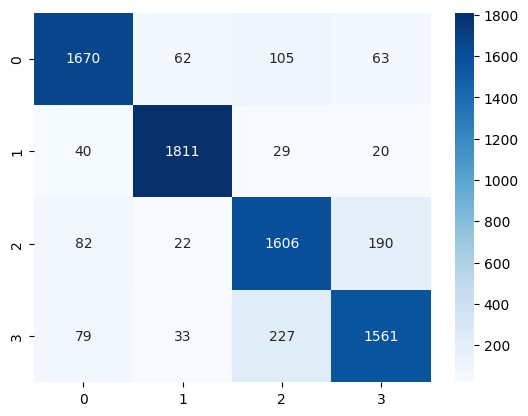

-------------------------------------------------------
(59352, 100)


V Loss: 0.3548, count: 1: 100%|██████████| 625/625 [00:14<00:00, 41.81it/s]


Epoch: 1, Train Loss: 0.4302, Val Loss: 0.3548


V Loss: 0.3366, count: 2: 100%|██████████| 625/625 [00:14<00:00, 41.81it/s]


Epoch: 2, Train Loss: 0.3495, Val Loss: 0.3366


V Loss: 0.3502, count: 3: 100%|██████████| 625/625 [00:15<00:00, 39.48it/s]


Epoch: 3, Train Loss: 0.3331, Val Loss: 0.3502


V Loss: 0.3314, count: 4: 100%|██████████| 625/625 [00:14<00:00, 42.47it/s]


Epoch: 4, Train Loss: 0.3251, Val Loss: 0.3314


V Loss: 0.3254, count: 5: 100%|██████████| 625/625 [00:14<00:00, 42.30it/s]


Epoch: 5, Train Loss: 0.3178, Val Loss: 0.3254


V Loss: 0.3241, count: 6: 100%|██████████| 625/625 [00:14<00:00, 42.04it/s]


Epoch: 6, Train Loss: 0.3128, Val Loss: 0.3241


V Loss: 0.3178, count: 7: 100%|██████████| 625/625 [00:14<00:00, 42.56it/s]


Epoch: 7, Train Loss: 0.3079, Val Loss: 0.3178


V Loss: 0.3157, count: 8: 100%|██████████| 625/625 [00:14<00:00, 42.41it/s]


Epoch: 8, Train Loss: 0.3039, Val Loss: 0.3157


V Loss: 0.3188, count: 9: 100%|██████████| 625/625 [00:14<00:00, 42.05it/s]


Epoch: 9, Train Loss: 0.3007, Val Loss: 0.3188


V Loss: 0.3220, count: 10: 100%|██████████| 625/625 [00:14<00:00, 42.80it/s]


Epoch: 10, Train Loss: 0.2976, Val Loss: 0.3220


V Loss: 0.3129, count: 11: 100%|██████████| 625/625 [00:15<00:00, 41.50it/s]


Epoch: 11, Train Loss: 0.2934, Val Loss: 0.3129


V Loss: 0.3174, count: 12: 100%|██████████| 625/625 [00:14<00:00, 42.21it/s]


Epoch: 12, Train Loss: 0.2908, Val Loss: 0.3174


V Loss: 0.3207, count: 13: 100%|██████████| 625/625 [00:14<00:00, 42.12it/s]


Epoch: 13, Train Loss: 0.2876, Val Loss: 0.3207


V Loss: 0.3177, count: 14: 100%|██████████| 625/625 [00:15<00:00, 40.84it/s]


Epoch: 14, Train Loss: 0.2861, Val Loss: 0.3177
Test Loss: 0.3285
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1900
           1       0.94      0.97      0.96      1900
           2       0.85      0.83      0.84      1900
           3       0.85      0.85      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

tensor([[0., 0., 1.]], device='cuda:0')


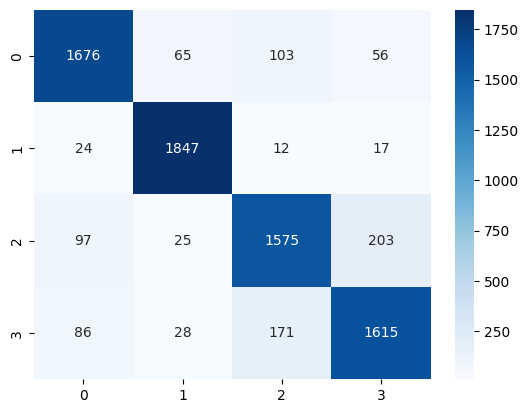

-------------------------------------------------------
(59352, 100)


V Loss: 0.5271, count: 1: 100%|██████████| 625/625 [00:15<00:00, 41.34it/s]


Epoch: 1, Train Loss: 0.5078, Val Loss: 0.5271


V Loss: 0.4457, count: 2: 100%|██████████| 625/625 [00:15<00:00, 40.14it/s]


Epoch: 2, Train Loss: 0.4309, Val Loss: 0.4457


V Loss: 0.4198, count: 3: 100%|██████████| 625/625 [00:14<00:00, 42.10it/s]


Epoch: 3, Train Loss: 0.4155, Val Loss: 0.4198


V Loss: 0.4484, count: 4: 100%|██████████| 625/625 [00:14<00:00, 42.28it/s]


Epoch: 4, Train Loss: 0.4064, Val Loss: 0.4484


V Loss: 0.4129, count: 5: 100%|██████████| 625/625 [00:14<00:00, 42.36it/s]


Epoch: 5, Train Loss: 0.4007, Val Loss: 0.4129


V Loss: 0.3973, count: 6: 100%|██████████| 625/625 [00:15<00:00, 41.09it/s]


Epoch: 6, Train Loss: 0.3943, Val Loss: 0.3973


V Loss: 0.3825, count: 7: 100%|██████████| 625/625 [00:14<00:00, 41.77it/s]


Epoch: 7, Train Loss: 0.3899, Val Loss: 0.3825


V Loss: 0.4459, count: 8: 100%|██████████| 625/625 [00:14<00:00, 42.16it/s]


Epoch: 8, Train Loss: 0.3877, Val Loss: 0.4459


V Loss: 0.3831, count: 9: 100%|██████████| 625/625 [00:14<00:00, 42.03it/s]


Epoch: 9, Train Loss: 0.3841, Val Loss: 0.3831


V Loss: 0.3846, count: 10: 100%|██████████| 625/625 [00:15<00:00, 40.74it/s]


Epoch: 10, Train Loss: 0.3811, Val Loss: 0.3846
Test Loss: 0.4006
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1900
           1       0.94      0.94      0.94      1900
           2       0.80      0.83      0.81      1900
           3       0.82      0.80      0.81      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600

tensor([[1., 2., 3.]], device='cuda:0')


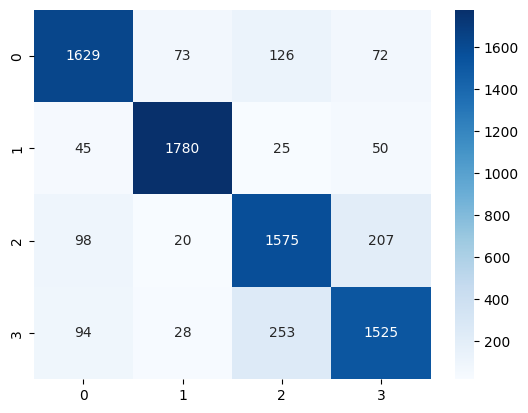

-------------------------------------------------------
(59352, 100)


V Loss: 0.4506, count: 1: 100%|██████████| 625/625 [00:15<00:00, 40.81it/s]


Epoch: 1, Train Loss: 0.5105, Val Loss: 0.4506


V Loss: 0.4112, count: 2: 100%|██████████| 625/625 [00:15<00:00, 41.26it/s]


Epoch: 2, Train Loss: 0.4351, Val Loss: 0.4112


V Loss: 0.4104, count: 3: 100%|██████████| 625/625 [00:15<00:00, 41.30it/s]


Epoch: 3, Train Loss: 0.4205, Val Loss: 0.4104


V Loss: 0.4018, count: 4: 100%|██████████| 625/625 [00:15<00:00, 40.92it/s]


Epoch: 4, Train Loss: 0.4086, Val Loss: 0.4018


V Loss: 0.4426, count: 5: 100%|██████████| 625/625 [00:15<00:00, 41.19it/s]


Epoch: 5, Train Loss: 0.4043, Val Loss: 0.4426


V Loss: 0.3871, count: 6: 100%|██████████| 625/625 [00:15<00:00, 41.29it/s]


Epoch: 6, Train Loss: 0.3997, Val Loss: 0.3871


V Loss: 0.3929, count: 7: 100%|██████████| 625/625 [00:14<00:00, 42.16it/s]


Epoch: 7, Train Loss: 0.3943, Val Loss: 0.3929


V Loss: 0.4186, count: 8: 100%|██████████| 625/625 [00:15<00:00, 41.43it/s]


Epoch: 8, Train Loss: 0.3913, Val Loss: 0.4186


V Loss: 0.3864, count: 9: 100%|██████████| 625/625 [00:14<00:00, 42.01it/s]


Epoch: 9, Train Loss: 0.3894, Val Loss: 0.3864


V Loss: 0.3907, count: 10: 100%|██████████| 625/625 [00:14<00:00, 41.90it/s]


Epoch: 10, Train Loss: 0.3873, Val Loss: 0.3907


V Loss: 0.3813, count: 11: 100%|██████████| 625/625 [00:15<00:00, 41.59it/s]


Epoch: 11, Train Loss: 0.3822, Val Loss: 0.3813


V Loss: 0.4142, count: 12: 100%|██████████| 625/625 [00:14<00:00, 41.93it/s]


Epoch: 12, Train Loss: 0.3801, Val Loss: 0.4142


V Loss: 0.3854, count: 13: 100%|██████████| 625/625 [00:15<00:00, 40.98it/s]


Epoch: 13, Train Loss: 0.3784, Val Loss: 0.3854


V Loss: 0.3807, count: 14: 100%|██████████| 625/625 [00:14<00:00, 42.04it/s]


Epoch: 14, Train Loss: 0.3757, Val Loss: 0.3807


V Loss: 0.4016, count: 15: 100%|██████████| 625/625 [00:14<00:00, 41.72it/s]


Epoch: 15, Train Loss: 0.3750, Val Loss: 0.4016


V Loss: 0.3846, count: 16: 100%|██████████| 625/625 [00:15<00:00, 41.63it/s]


Epoch: 16, Train Loss: 0.3747, Val Loss: 0.3846


V Loss: 0.3841, count: 17: 100%|██████████| 625/625 [00:14<00:00, 41.73it/s]


Epoch: 17, Train Loss: 0.3721, Val Loss: 0.3841
Test Loss: 0.3871
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1900
           1       0.91      0.96      0.93      1900
           2       0.84      0.78      0.81      1900
           3       0.81      0.83      0.82      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600

tensor([[1., 1., 1.]], device='cuda:0')


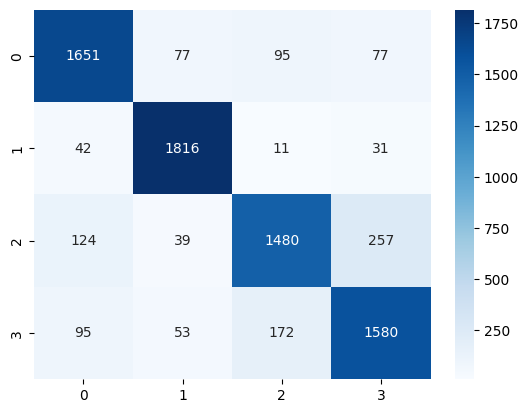

-------------------------------------------------------
(59352, 100)


V Loss: 0.4465, count: 1: 100%|██████████| 625/625 [00:15<00:00, 41.30it/s]


Epoch: 1, Train Loss: 0.5002, Val Loss: 0.4465


V Loss: 0.4294, count: 2: 100%|██████████| 625/625 [00:15<00:00, 41.29it/s]


Epoch: 2, Train Loss: 0.4397, Val Loss: 0.4294


V Loss: 0.4301, count: 3: 100%|██████████| 625/625 [00:15<00:00, 41.37it/s]


Epoch: 3, Train Loss: 0.4243, Val Loss: 0.4301


V Loss: 0.4288, count: 4: 100%|██████████| 625/625 [00:15<00:00, 41.15it/s]


Epoch: 4, Train Loss: 0.4140, Val Loss: 0.4288


V Loss: 0.4030, count: 5: 100%|██████████| 625/625 [00:15<00:00, 41.34it/s]


Epoch: 5, Train Loss: 0.4072, Val Loss: 0.4030


V Loss: 0.4099, count: 6: 100%|██████████| 625/625 [00:16<00:00, 38.38it/s]


Epoch: 6, Train Loss: 0.4056, Val Loss: 0.4099


V Loss: 0.4083, count: 7: 100%|██████████| 625/625 [00:15<00:00, 41.34it/s]


Epoch: 7, Train Loss: 0.3998, Val Loss: 0.4083


V Loss: 0.4051, count: 8: 100%|██████████| 625/625 [00:15<00:00, 40.46it/s]


Epoch: 8, Train Loss: 0.3963, Val Loss: 0.4051
Test Loss: 0.4136
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      1900
           1       0.93      0.94      0.94      1900
           2       0.82      0.77      0.80      1900
           3       0.77      0.87      0.81      1900

    accuracy                           0.85      7600
   macro avg       0.85      0.85      0.85      7600
weighted avg       0.85      0.85      0.85      7600

tensor([[1., 0., 0.]], device='cuda:0')


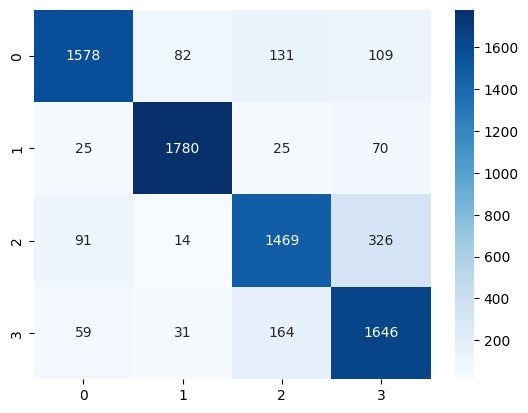

-------------------------------------------------------


In [28]:
delta_values = [None, [0, 0, 1], [1, 2, 3], [1, 1, 1], [1, 0, 0]]

# reshape delta values
for i in range(len(delta_values)):
    if delta_values[i] is not None:
        delta_values[i] = np.array(delta_values[i]).reshape(1, -1)
        delta_values[i] = torch.FloatTensor(delta_values[i]).cuda()

for delta in delta_values:
    downstream_model = Downstream_Model(embedding_matrix(word_to_ix, glove_vectors), 100, 2, 4, 0.2)
    downstream_model = downstream_model.cuda()
    if delta is not None:
        downstream_model.delta = nn.Parameter(delta, requires_grad=False)
    all_downstream_train_loss, all_downstream_val_loss, downstream_model = train_downstream_classifier('Adam', downstream_model)
    test_downstream_classifier(downstream_model)
    print(delta)
    plt.show()
    print('-------------------------------------------------------')


In [29]:
import pickle

results_dict = {
    'elmo_train_loss': all_emlo_train_loss,
    'elmo_val_loss': all_elmo_val_loss,
    'downstream_train_loss': all_downstream_train_loss,
    'downstream_val_loss': all_downstream_val_loss,
}

with open('results.pkl', 'wb') as pickle_file:
  pickle.dump(results_dict, pickle_file)

In [30]:
test_downstream_classifier()

TypeError: ignored

In [32]:
# get all the lists in the results.pkl file

import pickle

with open('results.pkl', 'rb') as pickle_file:
    results_dict = pickle.load(pickle_file)

all_emlo_train_loss = results_dict['elmo_train_loss']
all_elmo_val_loss = results_dict['elmo_val_loss']
all_downstream_train_loss = results_dict['downstream_train_loss']
all_downstream_val_loss = results_dict['downstream_val_loss']


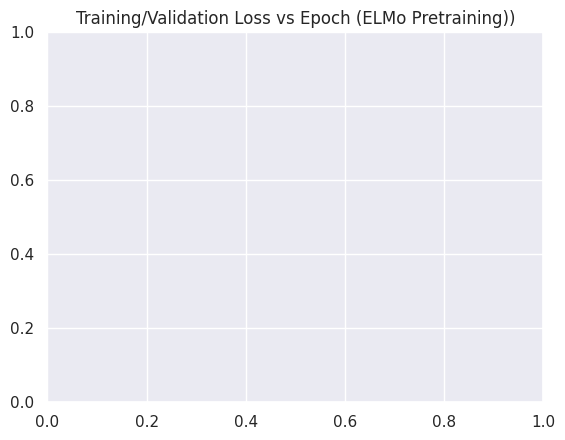

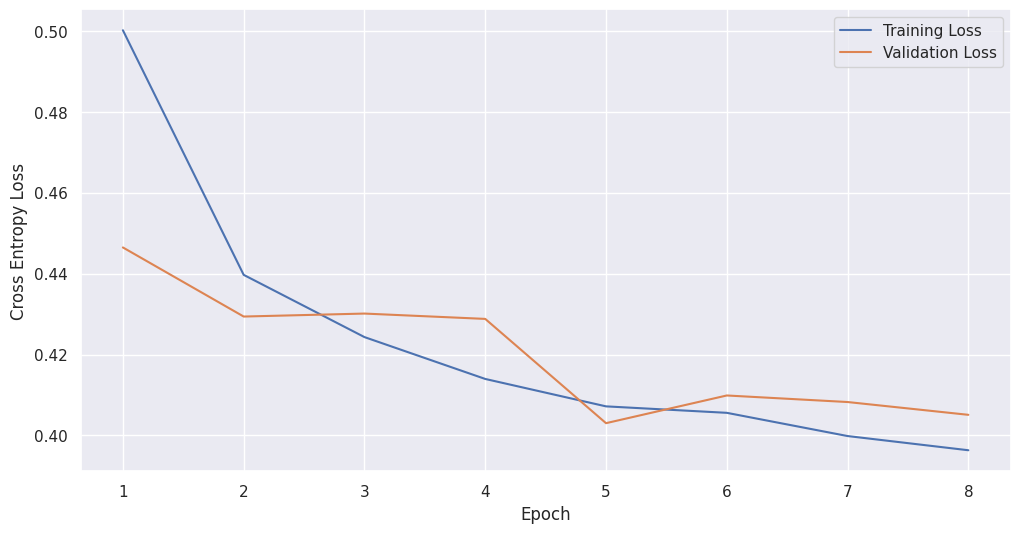

In [33]:
import numpy as np
def get_graph(train_loss, val_loss):
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.set()
    x = np.arange(1, len(train_loss) + 1)
    plt.title('Training/Validation Loss vs Epoch (ELMo Pretraining))')
    #increase width of graph
    plt.figure(figsize=(12, 6))
    plt.plot(x, train_loss, label='Training Loss')
    plt.plot(x, val_loss, label='Validation Loss')
    plt.xticks(x)
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()
    plt.show()

get_graph(all_downstream_train_loss, all_downstream_val_loss)